In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=5"
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import numpyro
import numpyro.distributions as dist
import arviz as az

from src import igp, data

print(jax.devices())
jax.config.update("jax_enable_x64", True)


[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4)]


In [4]:
df = pd.read_csv("./data/NYC.csv")
df.head()

,Age,RSL,AgeError,RSLError,Type
0,1857.5,-0.382722,1.25,0.020224,TG
1,1865.0,-0.390889,2.50,0.019072,TG
2,1875.0,-0.375111,2.50,0.038143,TG
3,1895.0,-0.303651,2.50,0.019982,TG
4,1905.0,-0.290822,2.50,0.029349,TG


In [40]:
eiv_input = data.preprocess(df)
print(eiv_input.keys())

dict_keys(['x', 'y', 'cov', 'x_star'])


In [ ]:
mcmc = numpyro.infer.MCMC(
    numpyro.infer.NUTS(
        igp.eiv_igp,
        dense_mass=True,
    ),
    num_warmup=200,
    num_samples=500,
    num_chains=1,
)
mcmc.run(
    jax.random.PRNGKey(1),
    **eiv_input,
    simplify=False,
)
mcmc.print_summary()  # ~27m

sample: 100%|██████████| 700/700 [26:00<00:00,  2.23s/it, 127 steps of size 1.16e-01. acc. prob=0.83]   


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -1.71      0.06     -1.70     -1.78     -1.60    375.74      1.00
         p      0.11      0.19      0.03      0.00      0.35     11.92      1.14
     sigma      0.02      0.01      0.02      0.01      0.03     20.97      1.07
     tau_g      0.10      0.03      0.10      0.05      0.15    184.31      1.01
    w_m[0]      0.28      0.88      0.30     -1.20      1.57    356.63      1.00
    w_m[1]      0.35      0.67      0.36     -0.58      1.57    378.06      1.00
    w_m[2]      0.40      0.54      0.40     -0.41      1.30    396.00      1.00
    w_m[3]      0.45      0.43      0.43     -0.19      1.21    409.19      1.00
    w_m[4]      0.50      0.35      0.49     -0.07      1.03    380.11      1.00
    w_m[5]      0.53      0.29      0.53      0.11      1.04    371.34      1.00
    w_m[6]      0.56      0.26      0.55      0.15      0.96    338.29      1.00
    w_m[7]      0.58      0

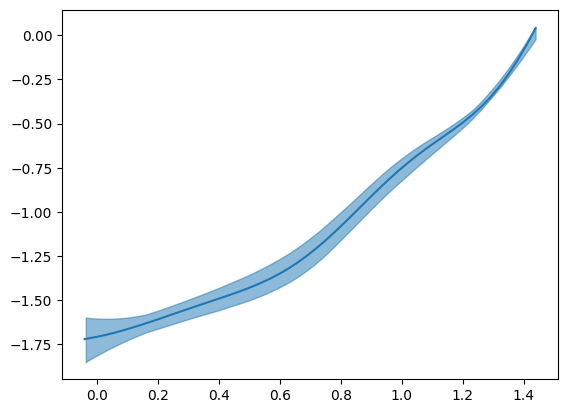

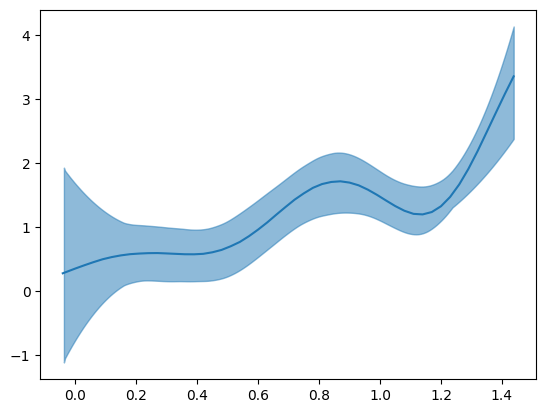

In [52]:
samples = mcmc.get_samples()
derp, intp = igp.get_predictions_on_grid(samples, eiv_input)

az.plot_hdi(eiv_input["x_star"], intp[None, :, :], color="C0")
plt.plot(eiv_input["x_star"], intp.mean(axis=0))
plt.show()
az.plot_hdi(eiv_input["x_star"], derp[None, :, :], color="C0")
plt.plot(eiv_input["x_star"], derp.mean(axis=0))
plt.show()

## svi


In [54]:
from numpyro.infer import SVI, Trace_ELBO, autoguide
import optax

guide = autoguide.AutoMultivariateNormal(
    igp.eiv_igp  # , init_loc_fn=numpyro.infer.init_to_median
)
optimizer = optax.adamw(learning_rate=1e-2)
svi = SVI(igp.eiv_igp, guide, optimizer, loss=Trace_ELBO())

svi_result = svi.run(
    jax.random.PRNGKey(0),
    num_steps=10_000,
    **eiv_input,
    progress_bar=True,
)

100%|██████████| 10000/10000 [02:46<00:00, 60.17it/s, init loss: 8823938.1615, avg. loss [9501-10000]: 562.8049]


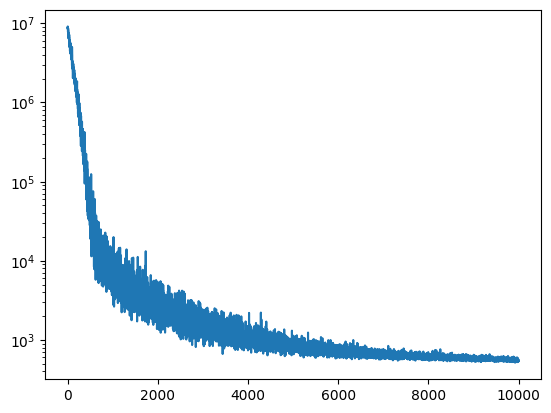

In [59]:
plt.plot(svi_result.losses)
plt.yscale("log")

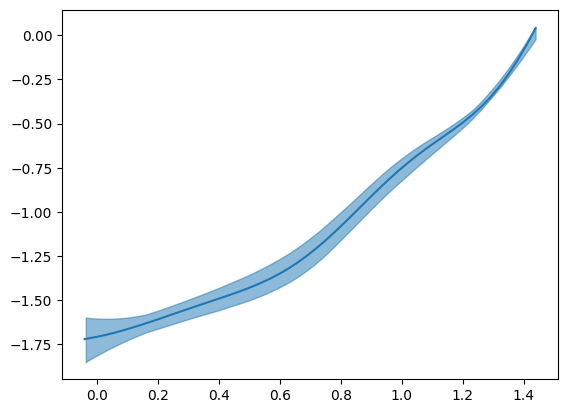

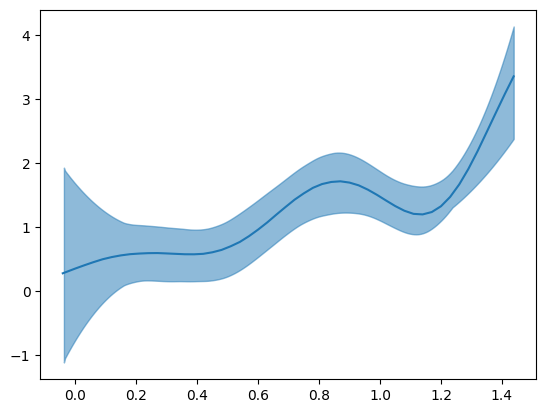

In [57]:
samples_svi = guide.sample_posterior(
    jax.random.PRNGKey(1),
    svi_result.params,
    sample_shape=(1000,),  # Number of samples to draw
)

derp, intp = igp.get_predictions_on_grid(samples, eiv_input)

az.plot_hdi(eiv_input["x_star"], intp[None, :, :], color="C0")
plt.plot(eiv_input["x_star"], intp.mean(axis=0))
plt.show()
az.plot_hdi(eiv_input["x_star"], derp[None, :, :], color="C0")
plt.plot(eiv_input["x_star"], derp.mean(axis=0))
plt.show()
